In [1]:
import sys
src_dir = '/Users/palmerio/Science_projects/GRB_population_model/grbpop/'
sys.path.insert(0, src_dir)

# GRB pop module imports
from GRB_population import GRBPopulation
import physics as ph
import stats as st
import io_grb_pop as io
from io_grb_pop import root_dir
import miscellaneous as msc
import plotting_functions as pf
from cosmology import init_cosmology
from ECLAIRs import init_ECLAIRs
from cosmology import create_cosmology, init_cosmology
import functional_forms as ff

# General imports
import yaml
import logging
import corner
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path
import scipy.integrate as integrate
from scipy.stats import mstats
from collections import OrderedDict
from itertools import cycle



log = logging.getLogger(__name__)
logging.basicConfig(stream=sys.stdout, level=logging.INFO,
                    format='%(asctime)s.%(msecs)03d [%(levelname)s] %(message)s',
                    datefmt='%H:%M:%S')
logging.getLogger('matplotlib').setLevel(logging.WARNING)
plt.style.use('paper')
colors = ['#225ea8', '#41b6c4', '#d94801', '#fd8d3c']

In [64]:
# This plot is to show an example of a bad fit to the observational constraints

plt.style.use('presentation')

fnames = {'k0_LN_nSFR':'180115_Sch_LogNorm_newSFR0',
          'kF_LN_nSFR':'180402_Schevol_LogNorm_newSFR0',
          'k0_LN_nF':'180509_S_LN_nS',
          'k05_LN_nF':'180416_Se_LN_nS',
          'k1_LN_nF':'180509_Se1_LN_nS',
          'k2_LN_nF':'180430_Se_LN_nS',
          'k0_A_nSFR':'180430_S_A_nS0',
          'kF_A_nSFR':'180402_Schevol_Amati_newSFR0',
          'k0_A_nF':'180430_S_A_nS',
          'k05_A_nF': '200409_Se05_A_nF',
          'k1_A_nF': '180510_Se1_A_nS',
          'k2_A_nF': '180509_Se_A_nS',
         }


def extract_quantity(array_from_binary, quantity_index, model_index, subindex=None):
    """
    Extracts a quantity from a binary-extracted array.
    Binary file is an output of the fortran MC GRB population code.

    Parameters:
    -----------

    quantity_index [int]
        The index where to find the property

    model_index [int]
        The index of the model you want to extract.
    """
    if subindex is None:
        quantity = array_from_binary[model_index][quantity_index]
    else:
        quantity = array_from_binary[model_index][quantity_index][subindex]

    return quantity

def extract_constraint(array_from_binary, constraint_index, model_index):
    """
        Extracts a property distribution from a binary-extracted array.
        Binary file is an output of the fortran MC GRB population code.

        Parameters:
        -----------

        constraint_index [int]
            The index where to find the property:
                Kommers       : 18
                Preece        : 19
                Stern         : 20
                EpGBM         : 21
                eBAT6         : 22
            Note : add 2 to each of these since the addition of tau, the temperature in the annealing version of the MCMC


        model_index [int]
            The index of the model you want to extract.

        len_constraint_array [int]
            The length of the property array to extract:
                Kommers       : 25
                Preece        : 10
                Stern         : 27
                EpGBM         : 9
                eBAT6         : 15

    """

    constraint_distr = array_from_binary[model_index][constraint_index]

    return constraint_distr


def post_process_constraint(array_from_binary, constraint_index, start, stop, len_constraint_array, one_plot_mode=False):
    """
        Post processes the output from the MC GRB population code for a given constraint.
        Start and stop are the indexes at which the chain is considered valid.
        Returns the median value for each bin and the + and - 1 sigma  errors.

    """
    if one_plot_mode:
        # stop and start are lists in this mode
        for j in range(len(stop)):
            if stop[j] > len(array_from_binary):
                stop[j] = len(array_from_binary)

            constraint_j = np.zeros((stop[j]-start[j],len_constraint_array))

            for i in range(start[j],stop[j]):
                constraint_j[i-start[j],:] = extract_constraint(array_from_binary, constraint_index, i)

            if j == 0:
                constraint = constraint_j
            else:
                constraint = np.concatenate((constraint, constraint_j))
    else:
        if stop > len(array_from_binary):
            stop = len(array_from_binary)

        constraint = np.zeros((stop-start,len_constraint_array))

        for i in range(start,stop):
            constraint[i-start,:] = extract_constraint(array_from_binary, constraint_index, i)

    constraint_final = np.median(constraint, axis=0)
    constraint_final_errp = np.zeros(len_constraint_array)
    constraint_final_errm = np.zeros(len_constraint_array)

    constraint_transposed = np.transpose(constraint)
    for i in range(len(constraint_transposed)):
        q = mstats.mquantiles(constraint_transposed[i], prob=[0.16, 0.5, 0.84])
        constraint_final_errp[i] = q[2] - q[1]
        constraint_final_errm[i] = q[1] - q[0]

    return constraint_final, constraint_final_errp, constraint_final_errm

# base_dir = Path('/Volumes/LACIE SHARE/palmerio/Model_outputs')
base_dir = Path('../model_outputs_non-dockerized/')

def plot_constraint_from_MCMC(model, constraint, ax, version=1, color=None):
    if constraint not in ['Stern', 'EpGBM', 'eBAT6']:
        raise ValueError("constraint must be one of {}".format(['Stern', 'EpGBM', 'eBAT6']))
    
    starts = io.read_column(base_dir/model/'chain_index.txt', 0, splitter=',', dtype=int)
    stops  = io.read_column(base_dir/model/'chain_index.txt', 1, splitter=',', dtype=int)
    print('Model : {}'.format(model))
    print('Start, stop: {}, {}'.format(starts, stops))
    
    fname = base_dir/model/'reprise_MCMC.dat'
    if constraint == 'Stern':
        index = 22
        len_constraint = 27
    elif constraint == 'EpGBM':
        index = 23
        len_constraint = 9
    elif constraint == 'eBAT6':
        index = 24
        len_constraint = 15

    if version == 1:
        dt = np.dtype("i4, 24i4, 10f8, 10f8, 6f8, 6f8, 7f8, 7f8, 5f8, i4, f8, i4, 10f8, 10f8, 6f8, 500f8, 400f8, 200f8, 200f8, 360f8, 25f8, 10f8, 27f8, 9f8, 15f8, i4")
    elif version == 2:
        dt = np.dtype("i4, 24i4, 10f8, 10f8, 6f8, 6f8, 7f8, 7f8, 5f8, 2i4, f8, 10f8, 10f8, 6f8, 550f8, 440f8, 220f8, 220f8, 400f8, 25f8, 10f8, 27f8, 9f8, 15f8, i4")
        index -= 1

    # read the data
    with open(fname, 'rb') as f:
        sim_output_data = np.fromfile(f, dtype=dt, count=-1)

    # Extract the data you want
    y_mod, y_mod_errp, y_mod_errm = post_process_constraint(sim_output_data, 
                                                            index, starts, stops, 
                                                            len_constraint,
                                                            one_plot_mode=True)
    if constraint == 'Stern':
        bins, obs_lin, err_lin = obs.create_Stern_hist()
        # Convert to log
        y_mod, y_mod_errp, y_mod_errm = msc.lin_to_log(y_mod, y_mod_errp, y_mod_errm)
    elif (constraint == 'EpGBM') or (constraint == 'eBAT6'):
        # Turn histogram into density
        if constraint == 'EpGBM':
            bins, obs_lin, err_lin = obs.create_EpGBM_hist(bins_log=True)
        elif constraint == 'eBAT6':
            bins, obs_lin, err_lin = obs.create_eBAT6_hist()
        N_tot = np.sum(y_mod)
        delta_bin = bins[1:]-bins[:-1] 
        y_mod = y_mod/(N_tot*delta_bin)
        y_mod_errp = y_mod_errp/(N_tot*delta_bin)
        y_mod_errm = y_mod_errm/(N_tot*delta_bin)
        

    # Make it look better for plots
    x_plottable, y_mod_plottable = pf.plottable_hist(bins[:-1], y_mod, last_bin_edge=bins[-1])
    y_mod_errm_plottable = pf.double_array(y_mod_errm)
    y_mod_errp_plottable = pf.double_array(y_mod_errp)

    # Plot them
    art, = ax.plot(x_plottable, y_mod_plottable, label='Model', color=color, zorder=1)
    ax.fill_between(x_plottable,
                    y_mod_plottable+y_mod_errp_plottable,
                    y_mod_plottable-y_mod_errm_plottable,
                    alpha=0.6, color=plt.getp(art,'color'), zorder=plt.getp(art,'zorder'))
    return



10:23:38.036 [INFO] Processing k05_LN_nF
10:23:38.037 [INFO] Read data from binary file...
10:23:38.824 [INFO] Done
10:23:38.829 [INFO] Extracting data...
10:23:39.780 [INFO] Number of models: 75000
10:23:39.790 [INFO] Number of good models: 54631
10:23:39.815 [INFO] Number of models without duplicates: 16834
10:23:40.669 [WARNING] Too few points to create valid contours
10:23:40.684 [WARNING] Too few points to create valid contours
10:23:40.699 [WARNING] Too few points to create valid contours
10:23:40.750 [WARNING] Too few points to create valid contours
10:23:40.768 [WARNING] Too few points to create valid contours
10:23:40.785 [WARNING] Too few points to create valid contours
10:23:40.968 [WARNING] Too few points to create valid contours
10:23:41.001 [WARNING] Too few points to create valid contours
10:23:41.013 [WARNING] Too few points to create valid contours
10:23:41.028 [WARNING] Too few points to create valid contours
10:23:41.056 [WARNING] Too few points to create valid conto

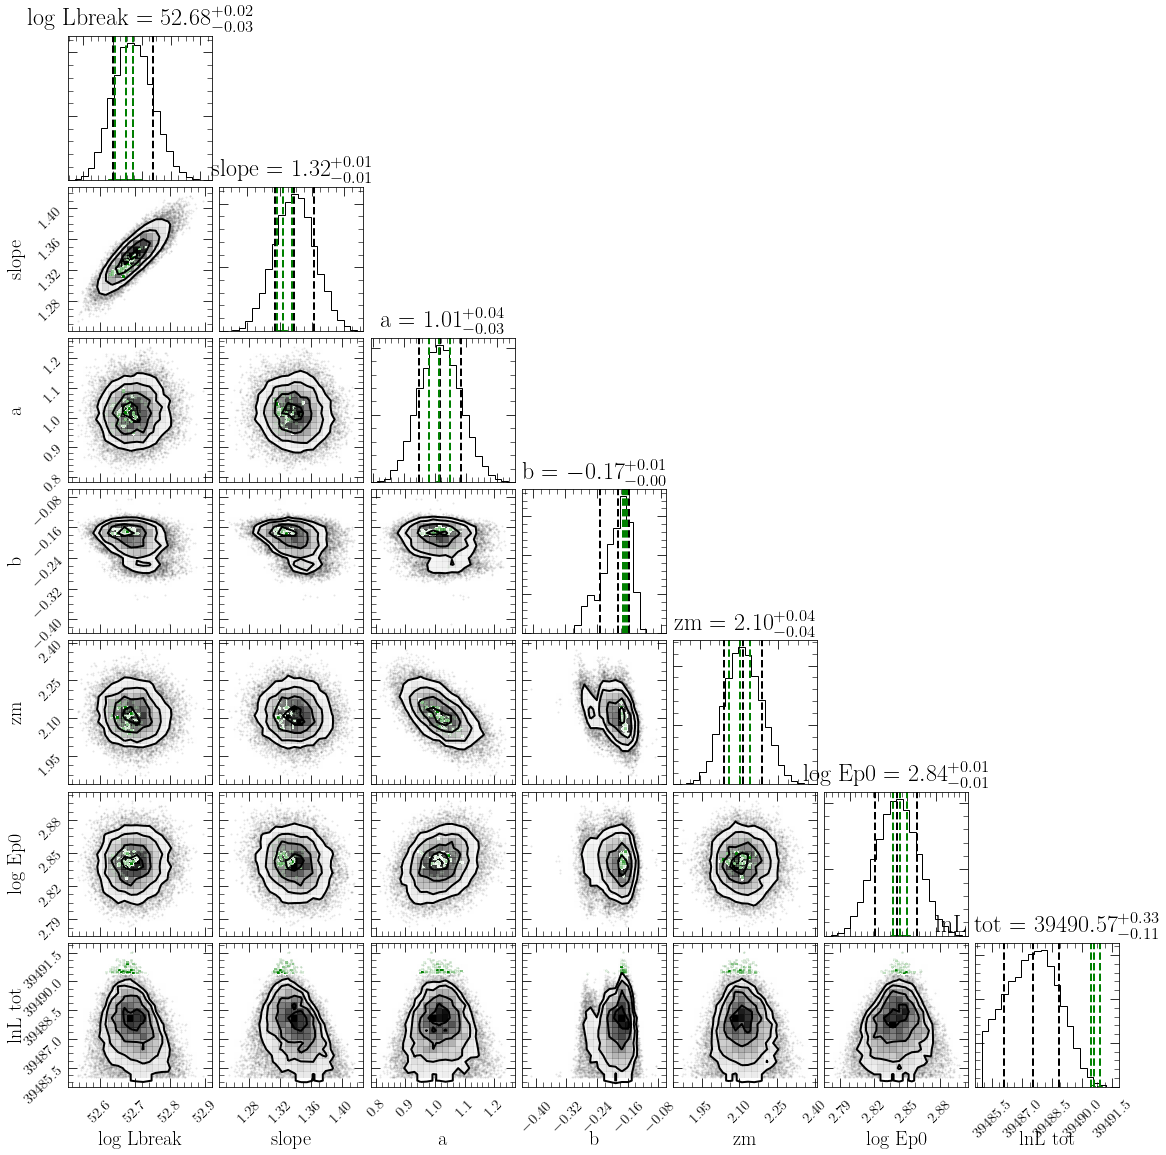

In [124]:
mod = 'k05_LN_nF'
# for mod in fnames.keys():

fname = base_dir/fnames[mod]/'reprise_MCMC.dat'

log.info('Processing {}'.format(mod))
dt = np.dtype("i4, 24i4, 10f8, 10f8, 6f8, 6f8, 7f8, 7f8, 5f8, i4, f8, i4, 10f8, 10f8, 6f8, 500f8, 400f8, 200f8, 200f8, 360f8, 25f8, 10f8, 27f8, 9f8, 15f8, i4")
if mod == 'k05_A_nF':
    dt = np.dtype("i4, 24i4, 10f8, 10f8, 6f8, 6f8, 7f8, 7f8, 5f8, 2i4, f8, 10f8, 10f8, 6f8, 550f8, 440f8, 220f8, 220f8, 400f8, 25f8, 10f8, 27f8, 9f8, 15f8, i4")

log.info('Read data from binary file...')
# read the data
with open(fname, 'rb') as f:
    sim_output_data = np.fromfile(f, dtype=dt, count=-1)
log.info('Done')
# print(sim_output_data)
z_indexes = [2, 3, 4]
L_indexes = [3, 4, 7]
Ep_indexes = [0, 1, 3]
chi2_indexes = [0, 3, 5, 6]
names = ['chi2 tot', 'chi2 Stern', 'chi2 EpGBM', 'chi2 eBAT6',
         'lnL tot', 'lnL Stern', 'lnL EpGBM', 'lnL eBAT6',
         'zm', 'a', 'b',
         'Lbreak', 'slope', 'k evol',
         'Ep0', 'sigma Ep', 'alpha amati',
         'T sim']

chi2 = np.zeros((len(sim_output_data), len(chi2_indexes)))
lnL = np.zeros((len(sim_output_data), len(chi2_indexes)))
param_z = np.zeros((len(sim_output_data), len(z_indexes)))
param_L = np.zeros((len(sim_output_data), len(L_indexes)))
param_Ep = np.zeros((len(sim_output_data), len(Ep_indexes)))
Tsim = np.zeros((len(sim_output_data), 1))

log.info('Extracting data...')
for i in range(len(sim_output_data)):
    param_z[i] = sim_output_data[i][3][z_indexes]
    param_L[i] = sim_output_data[i][2][L_indexes]
    param_Ep[i] = sim_output_data[i][5][Ep_indexes]
    chi2[i] = sim_output_data[i][6][chi2_indexes]
    lnL[i] = sim_output_data[i][7][chi2_indexes]
    Tsim[i] = 1./sim_output_data[i][8][1]

df_tot = pd.DataFrame(np.concatenate((chi2, lnL, param_z, param_L, param_Ep, Tsim), axis=1), columns=names)
log.info('Number of models: {}'.format(len(df_tot)))

# Check Chi2 and lnL distribution
cond = (df_tot['chi2 tot'] < 45) & (df_tot['lnL tot'] > 39485)
df_dupl = df_tot[cond].copy()
log.info('Number of good models: {}'.format(len(df_dupl)))
df = df_dupl.drop_duplicates(subset=['a','b','zm','Lbreak','slope', 'Ep0', 'sigma Ep', 'alpha amati']).copy()
df['log Lbreak'] = np.log10(df['Lbreak'])
df['log Ep0'] = np.log10(df['Ep0'])
log.info('Number of models without duplicates: {}'.format(len(df)))
df.sort_values(by='lnL tot', ascending=False, inplace=True)
param_to_show = ['log Lbreak','slope','k evol', 'a','b','zm', 'log Ep0', 'sigma Ep', 'alpha amati', 'lnL tot']
if 'kF' not in mod:
    param_to_show.remove('k evol')
if 'nSFR' in mod :
    param_to_show.remove('a')
    param_to_show.remove('b')
    param_to_show.remove('zm')
if 'LN' in mod:
    param_to_show.remove('alpha amati')
    if 'kF' not in mod:
        param_to_show.remove('sigma Ep')
fig = corner.corner(df[param_to_show],show_titles=True, quantiles=[0.16, 0.5, 0.84])
corner.corner(df[param_to_show][:100], show_titles=True, quantiles=[0.16, 0.5, 0.84],
              color='g', plot_contours=False, fig=fig)
axes = fig.axes
for ax in axes:
    ax.autoscale()
plt.show()

13:19:20.757 [INFO] Processing kF_LN_nSFR
13:19:20.759 [INFO] Read data from binary file...
13:19:21.452 [INFO] Done
13:19:21.454 [INFO] Extracting data...
13:19:22.428 [INFO] Number of models: 75000
13:19:22.432 [INFO] Number of models: 12359
13:19:22.439 [INFO] Number of models without duplicates: 3724
13:19:22.516 [INFO] Creating cosmology with: OmegaM = 0.27, OmegaL = 0.73, H0 = 71.0
13:19:22.571 [INFO] Creating z pdf...
13:19:22.680 [INFO] Calculating pseudo collapse rate...
13:19:22.722 [INFO] Done
13:19:22.925 [INFO] Normalizing redshift distribution...
13:19:22.931 [INFO] Done
13:19:22.932 [INFO] Starting calculation of redshift distribution uncertainty...
13:19:23.225 [INFO] Done


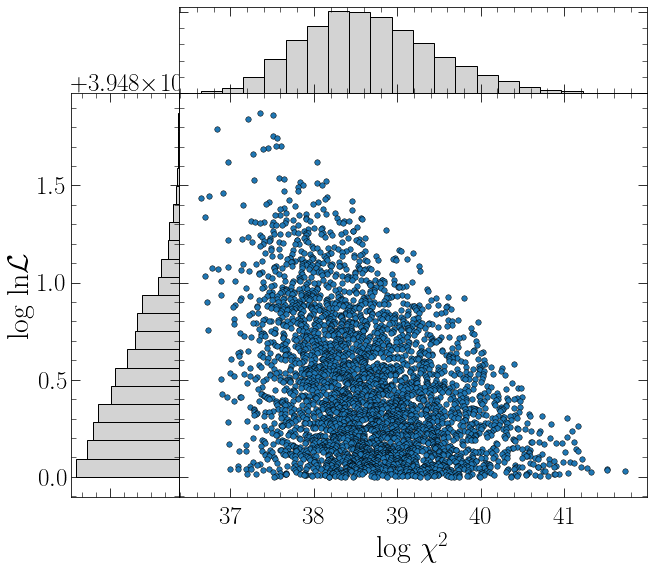

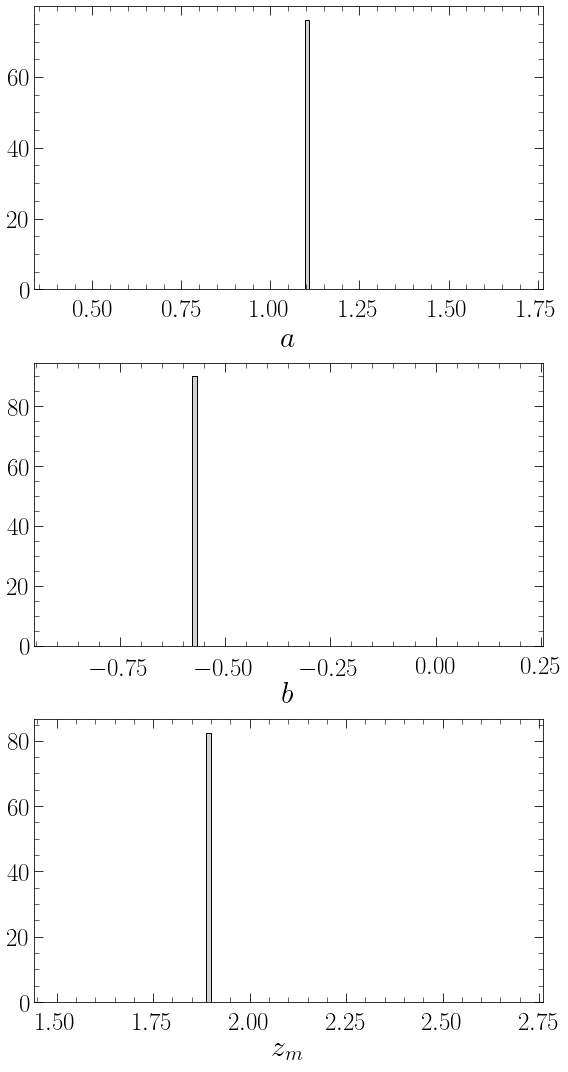

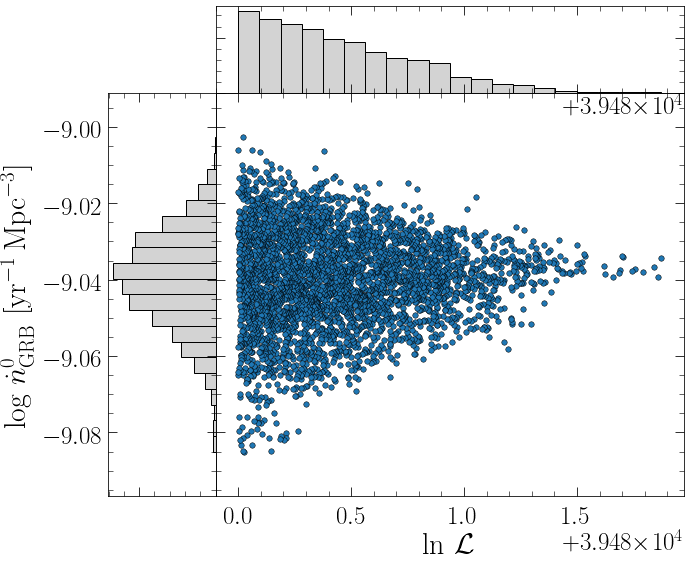

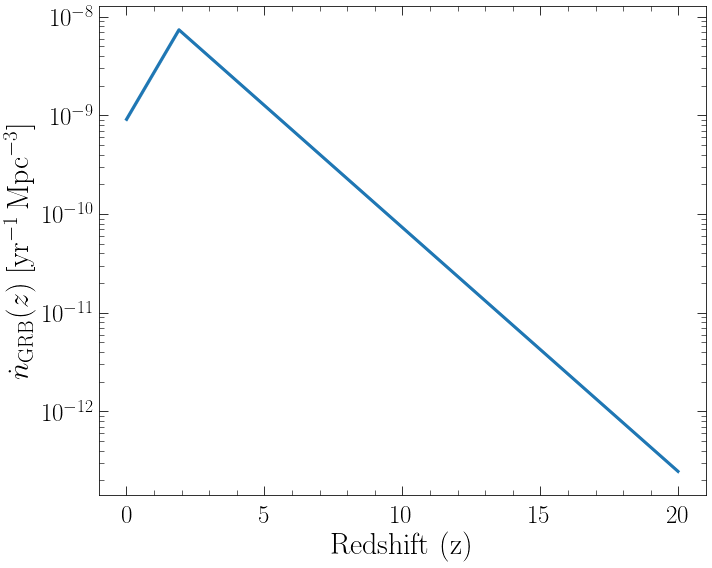

In [155]:
# for mod in fnames.keys(): #['k0_LN_nF', 'k05_LN_nF', 'k1_LN_nF', 'k2_LN_nF', 'k0_A_nF', 'k1_A_nF', 'k2_A_nF']:
mod = 'kF_LN_nSFR'
fname = base_dir/fnames[mod]/'reprise_MCMC.dat'

log.info('Processing {}'.format(mod))
dt = np.dtype("i4, 24i4, 10f8, 10f8, 6f8, 6f8, 7f8, 7f8, 5f8, i4, f8, i4, 10f8, 10f8, 6f8, 500f8, 400f8, 200f8, 200f8, 360f8, 25f8, 10f8, 27f8, 9f8, 15f8, i4")
if mod == 'k05_A_nF':
    dt = np.dtype("i4, 24i4, 10f8, 10f8, 6f8, 6f8, 7f8, 7f8, 5f8, 2i4, f8, 10f8, 10f8, 6f8, 550f8, 440f8, 220f8, 220f8, 400f8, 25f8, 10f8, 27f8, 9f8, 15f8, i4")

log.info('Read data from binary file...')
# read the data
with open(fname, 'rb') as f:
    sim_output_data = np.fromfile(f, dtype=dt, count=-1)
log.info('Done')

z_indexes = [2, 3, 4]
L_indexes = [3, 4, 7]
Ep_indexes = [0, 1, 3]
chi2_indexes = [0, 3, 5, 6]
names = ['chi2_tot', 'chi2_Stern', 'chi2_EpGBM', 'chi2_eBAT6',
         'lnL_tot', 'lnL_Stern', 'lnL_EpGBM', 'lnL_eBAT6',
         'zm', 'a', 'b',
         'Lbreak', 'slope', 'k_evol',
         'Ep0', 'sigma_Ep', 'alpha_amati',
         'T_sim']

chi2 = np.zeros((len(sim_output_data), len(chi2_indexes)))
lnL = np.zeros((len(sim_output_data), len(chi2_indexes)))
param_z = np.zeros((len(sim_output_data), len(z_indexes)))
param_L = np.zeros((len(sim_output_data), len(L_indexes)))
param_Ep = np.zeros((len(sim_output_data), len(Ep_indexes)))
Tsim = np.zeros((len(sim_output_data), 1))

log.info('Extracting data...')
for i in range(len(sim_output_data)):
    param_z[i] = sim_output_data[i][3][z_indexes]
    param_L[i] = sim_output_data[i][2][L_indexes]
    param_Ep[i] = sim_output_data[i][5][Ep_indexes]
    chi2[i] = sim_output_data[i][6][chi2_indexes]
    lnL[i] = sim_output_data[i][7][chi2_indexes]
    Tsim[i] = 1./sim_output_data[i][8][1]

df_tot = pd.DataFrame(np.concatenate((chi2, lnL, param_z, param_L, param_Ep, Tsim), axis=1), columns=names)
log.info('Number of models: {}'.format(len(df_tot)))


# Check Chi2 and lnL distribution
cond = (df_tot['chi2_tot'] < 45) & (df_tot['lnL_tot'] > 39480)
df_dupl = df_tot[cond].copy()
log.info('Number of models: {}'.format(len(df_dupl)))
df = df_dupl.drop_duplicates(subset=['a','b','zm','Lbreak','slope', 'Ep0', 'sigma_Ep', 'alpha_amati']).copy()
log.info('Number of models without duplicates: {}'.format(len(df)))
df.sort_values(by='lnL_tot', ascending=False, inplace=True)
ind_max = np.min([len(df), 5000])
df = df[:ind_max].copy()

plt.style.use('paper')
fig, axes = pf.cool_hist2d(df['chi2_tot'].to_numpy(), 
                           df['lnL_tot'].to_numpy(),
                           plot_left_kdeplot=False, plot_top_kdeplot=False, linewidth=0.5,
                           s=30, mode='scatter', cb=False, xlabel=r'log $\chi^2$', ylabel=r'log ln$\mathcal{L}$')

cosmo = create_cosmology(OmegaM=0.27, OmegaL=0.73, h=0.71, z_step=0.02)
redshift = cosmo['redshift']
dVdz = cosmo['dVdz']
z_range = redshift[redshift <= 20.]
comoving_volume = dVdz[redshift <= 20.] / (1. + z_range)


log.info('Creating z pdf...')
z_pdf_comov = ff.BExp(z_range[:,np.newaxis], 
                      a=df['a'].to_numpy(), 
                      b=df['b'].to_numpy(), 
                      zm=df['zm'].to_numpy(), 
                      SFR_norm=1, IMF_norm=1)
log.info('Calculating pseudo collapse rate...')
pseudo_collapse_rate = integrate.trapz(z_pdf_comov * comoving_volume[:,np.newaxis], z_range, axis=0)
df['pcr'] = pseudo_collapse_rate
df['nGRB0'] = float(1e6) / (df['T_sim'] * df['pcr'])
log.info('Done')

# Check a, b, zm distribution
fig, axes = plt.subplots(3, figsize=(8,15))
axes[0].hist(df['a'], bins=np.linspace(0.4,1.7,100), color='lightgrey', density=True)
axes[1].hist(df['b'], bins=np.linspace(-0.9,0.2,100), color='lightgrey', density=True)
axes[2].hist(df['zm'], bins=np.linspace(1.5,2.7,100), color='lightgrey', density=True)
axes[0].set_xlabel(r'$a$')
axes[1].set_xlabel(r'$b$')
axes[2].set_xlabel(r'$z_m$')

# Check nGRB0 distribution
fig, axes = pf.cool_hist2d(df['lnL_tot'].to_numpy(), 
                           np.log10(df['nGRB0']).to_numpy(),
                           plot_left_kdeplot=False, plot_top_kdeplot=False, linewidth=0.5,
                           s=30, mode='scatter', cb=False, xlabel=r'ln $\mathcal{L}$',
                           ylabel=r' log $\dot{n}_{\rm GRB}^{0}~[\rm yr^{-1}\,Mpc^{-3}]$')

# calculate median redshift distribution and its error
log.info('Normalizing redshift distribution...')
z_distr = z_pdf_comov * df['nGRB0'].to_numpy()
log.info('Done')
log.info('Starting calculation of redshift distribution uncertainty...')
q = mstats.mquantiles(z_distr, prob=[0.16, 0.5, 0.84], axis=1)
log.info('Done')

fig, ax = plt.subplots()
ax.plot(z_range, q.T[1], color='C0')
ax.fill_between(z_range, q.T[0], q.T[2] , color='C0', alpha=0.5)
ax.set_yscale('log')
ax.set_xlabel('Redshift (z)')
ax.set_ylabel(r'$\dot{n}_{\rm GRB}(z)~[\rm yr^{-1}\,Mpc^{-3}$]')


outfname = '../model_outputs_non-dockerized/best_populations/z_distr_{}.txt'.format(mod)
with open(outfname, 'w') as f:
    f.write('# z \t lower \t median \t upper\n')
    for i in range(len(z_range)):
        f.write("{:.5e}\t{:.5e}\t{:.5e}\t{:.5e}\n".format(z_range[i], q.T[0][i], q.T[1][i], q.T[2][i]))

df.to_pickle(f'../model_outputs_non-dockerized/best_populations/params_from_MCMC_{mod}.gzip')
plt.show()


In [157]:
R_highz

{'k0_LN_nF': array([[[1.83579689e+02, 1.88281526e+02, 1.28419790e+02, 6.72265604e+01],
         [1.32414271e+02, 1.34688906e+02, 8.93210335e+01, 4.16507863e+01],
         [9.22059364e+01, 9.39119127e+01, 5.90018131e+01, 2.40639741e+01],
         ...,
         [2.39946254e+00, 1.85854324e+00, 3.19003691e-01, 0.00000000e+00],
         [7.76704639e-01, 6.10267930e-01, 4.16091771e-02, 0.00000000e+00],
         [2.91264240e-01, 1.38697257e-01, 0.00000000e+00, 0.00000000e+00]],
 
        [[1.78944381e+02, 1.82668639e+02, 1.26458644e+02, 6.57352355e+01],
         [1.28258471e+02, 1.31152040e+02, 8.77485094e+01, 4.14929446e+01],
         [8.98806126e+01, 9.19711814e+01, 5.77467707e+01, 2.42838254e+01],
         ...,
         [2.53360322e+00, 2.06287913e+00, 2.90741353e-01, 0.00000000e+00],
         [9.96827497e-01, 7.33775796e-01, 4.15344790e-02, 0.00000000e+00],
         [2.76896527e-01, 1.66137916e-01, 0.00000000e+00, 0.00000000e+00]],
 
        [[4.05982180e+02, 4.13596954e+02, 2.85457152e+

In [3]:
R_highz = {}
likelihoods = {}
normalizations = {}
paths_to_dir, paths_to_files = io.generate_paths()
config, params, instruments, samples, obs_constraints = io.read_init_files(paths_to_files)
cosmo = init_cosmology(paths_to_dir['cosmo'])
config['samples'] = ['Stern', 'EpGBM', 'eBAT6', 'THESEUS', 'ECLAIRsS']
config['constraints'] = ['Stern', 'EpGBM', 'eBAT6']

incl_samples, incl_instruments, incl_constraints = io.create_config(config=config,
                                                       samples=samples,
                                                       instruments=instruments,
                                                       obs_constraints=obs_constraints)
incl_instruments = OrderedDict(incl_instruments)
key_order= ['THESEUS', 'ECLAIRsS', 'BAT', 'BATSE']
for k in key_order: # a loop to force the order you want
    incl_instruments.move_to_end(k)


17:44:11.842 [INFO] Including samples: ['Stern', 'EpGBM', 'eBAT6', 'THESEUS', 'ECLAIRsS']
17:44:11.844 [INFO] Including instruments: ['BATSE', 'BAT', 'THESEUS', 'ECLAIRsS']
17:44:11.845 [INFO] Including constraints: ['Stern', 'EpGBM', 'eBAT6']


In [156]:

mod = 'kF_LN_nSFR'
N_models = 100
pflx_cuts = np.logspace(-1.7,1., 11)
z_cut = 6
Nb_GRBs = int(5e5)

# for mod in ['k0_LN_nF', 'k05_LN_nF', 'k1_LN_nF', 'k2_LN_nF', 'k0_A_nF', 'k1_A_nF', 'k2_A_nF']:

R_highz[mod] = np.zeros((N_models, len(pflx_cuts),len(incl_instruments.keys())))
likelihoods[mod] = np.zeros((N_models, 8))
normalizations[mod] = np.zeros((N_models, 2))

df = pd.read_pickle(root_dir/f'model_outputs_non-dockerized/best_populations/params_from_MCMC_{mod}.gzip')
print(df)
for i in range(N_models):
    log.info('Starting for model {} of {} ({:.1f}%)'.format(i, N_models, 100.*float(i)/N_models))
    params['luminosity_function']={'model':'ES',
                                  'logLbreak':np.log10(df['Lbreak'].iloc[i]),
                                  'slope':df['slope'].iloc[i],
                                  'logLmin':49.6989700043,
                                  'k_evol':df['k_evol'].iloc[i]}
    params['redshift_distribution']={'model':'BExp',
                                    'zm':df['zm'].iloc[i],
                                    'a':df['a'].iloc[i],
                                    'b':df['b'].iloc[i]}
    params['peak_energy_distribution']={'model':mod.split('_')[1],
                                        'Ep0':df['Ep0'].iloc[i],
                                        'sigmaEp':df['sigma_Ep'].iloc[i],
                                        'alpha_amati':df['alpha_amati'].iloc[i],
                                        'L0': 1.6e52}
    params['spectral_shape']={'model':'GBM',
                              'shape':'Band'}

    gp = GRBPopulation(Nb_GRBs=Nb_GRBs)
    gp.draw_GRB_properties_for_MCMC(cosmo, params, incl_instruments)
    gp.calc_peak_photon_flux(incl_instruments)
#     gp.calc_peak_energy_flux(incl_instruments)
#     gp.calc_photon_fluence(incl_instruments)
#     gp.calc_energy_fluence(incl_instruments)
#     gp.calc_det_prob(incl_samples)
    gp.create_mock_constraints()
    gp.compare_to_observational_constraints(constraints=incl_constraints)
    gp.normalize_to_Stern()
#         gp.normalize_from(nGRB0=df['nGRB0'].iloc[i])

    likelihoods[mod][i,0] = gp.likelihood_params['chi2_tot']
    likelihoods[mod][i,1] = gp.likelihood_params['chi2_Stern']
    likelihoods[mod][i,2] = gp.likelihood_params['chi2_EpGBM']
    likelihoods[mod][i,3] = gp.likelihood_params['chi2_eBAT6']
    likelihoods[mod][i,4] = gp.likelihood_params['lnL_tot']
    likelihoods[mod][i,5] = gp.likelihood_params['lnL_Stern']
    likelihoods[mod][i,6] = gp.likelihood_params['lnL_EpGBM']
    likelihoods[mod][i,7] = gp.likelihood_params['lnL_eBAT6']
    normalizations[mod][i,0] = gp.normalization['nGRB0']
    normalizations[mod][i,1] = gp.normalization['T_sim']
#     # Observational constraints
#     plt.style.use('presentation')
#     color='C1'
#     fig, axes = plt.subplots(1,3, figsize=(15,4), tight_layout=False)
#     pf.plot_intensity_constraint(axes[0], pop=gp, color=color)
#     pf.plot_spectral_constraint(axes[1], pop=gp, color=color)
#     pf.plot_redshift_constraint(axes[2], pop=gp, color=color)
#     axes[2].hist(gp.properties['z'], color=color, linewidth=1, bins=np.linspace(0,6,31),
#                  ls='--', alpha=0.8, density=True, histtype='step', zorder=10)

#     gp.summary()
#     log.info('Chi2 from F90: {:.2f}'.format(df['chi2_tot'].iloc[i]))
#     log.info('lnL from F90: {:.2f}'.format(df['lnL_tot'].iloc[i]))

    for ii, pflx_cut in enumerate(pflx_cuts):
        for j, ins in enumerate(incl_instruments.keys()):
            cond = (gp.properties[f'pht_pflx_{ins}'] >= pflx_cut) & (gp.properties['z'] >= z_cut)
            R_highz[mod][i,ii,j] = len(gp.properties[cond])/gp.normalization['T_sim']

    #     plt.show()

        chi2_tot  chi2_Stern  chi2_EpGBM  chi2_eBAT6       lnL_tot  \
57202  37.355189   21.525765   10.849894    4.979529  39481.872684   
42471  37.512465   21.926124   10.602421    4.983920  39481.860222   
19457  37.207589   21.539114   10.704428    4.964048  39481.840838   
10328  36.832929   21.324637   10.566890    4.941401  39481.791917   
59712  37.513510   21.765926   10.764334    4.983249  39481.756449   
...          ...         ...         ...         ...           ...   
1823   38.879285   22.865213   10.873287    5.140785  39480.000704   
45783  37.518649   21.794178   10.507013    5.217459  39480.000631   
69016  39.987693   22.990739   12.006367    4.990587  39480.000517   
12992  39.736925   22.573475   12.137817    5.025633  39480.000247   
69774  39.643938   23.305766   11.357943    4.980230  39480.000065   

          lnL_Stern    lnL_EpGBM  lnL_eBAT6   zm    a     b        Lbreak  \
57202  34424.776320  4163.365727  89.373064  1.9  1.1 -0.57  2.311287e+52   
42471

13:32:31.575 [INFO] Starting calculations of peak photon fluxes...
13:32:43.594 [INFO] Starting for model 27 of 100 (27.0%)
13:32:43.909 [INFO] Starting calculations of peak photon fluxes...
13:32:59.723 [INFO] Starting calculations of peak photon fluxes...
13:33:11.759 [INFO] Starting for model 28 of 100 (28.0%)
13:33:12.088 [INFO] Starting calculations of peak photon fluxes...
13:33:27.942 [INFO] Starting calculations of peak photon fluxes...
13:33:40.052 [INFO] Starting for model 29 of 100 (29.0%)
13:33:40.371 [INFO] Starting calculations of peak photon fluxes...
13:33:56.330 [INFO] Starting calculations of peak photon fluxes...
13:34:08.341 [INFO] Starting for model 30 of 100 (30.0%)
13:34:08.656 [INFO] Starting calculations of peak photon fluxes...
13:34:24.484 [INFO] Starting calculations of peak photon fluxes...
13:34:36.561 [INFO] Starting for model 31 of 100 (31.0%)
13:34:36.884 [INFO] Starting calculations of peak photon fluxes...
13:34:52.818 [INFO] Starting calculations of 

13:52:58.840 [INFO] Starting calculations of peak photon fluxes...
13:53:11.107 [INFO] Starting for model 70 of 100 (70.0%)
13:53:11.441 [INFO] Starting calculations of peak photon fluxes...
13:53:27.460 [INFO] Starting calculations of peak photon fluxes...
13:53:39.756 [INFO] Starting for model 71 of 100 (71.0%)
13:53:40.074 [INFO] Starting calculations of peak photon fluxes...
13:53:56.284 [INFO] Starting calculations of peak photon fluxes...
13:54:08.589 [INFO] Starting for model 72 of 100 (72.0%)
13:54:08.897 [INFO] Starting calculations of peak photon fluxes...
13:54:25.176 [INFO] Starting calculations of peak photon fluxes...
13:54:37.411 [INFO] Starting for model 73 of 100 (73.0%)
13:54:37.732 [INFO] Starting calculations of peak photon fluxes...
13:54:53.870 [INFO] Starting calculations of peak photon fluxes...
13:55:06.069 [INFO] Starting for model 74 of 100 (74.0%)
13:55:06.379 [INFO] Starting calculations of peak photon fluxes...
13:55:22.581 [INFO] Starting calculations of 

################# kF_LN_nSFR ################
################## k0_LN_nF #################
################# k05_LN_nF #################
################## k1_LN_nF #################
################## k2_LN_nF #################
################# kF_A_nSFR #################
################## k0_A_nF ##################
################## k05_A_nF #################
################## k1_A_nF ##################
################## k2_A_nF ##################


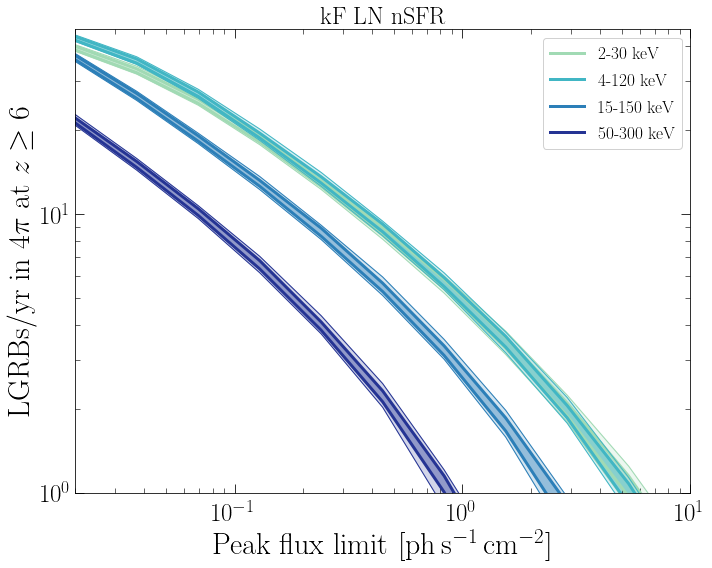

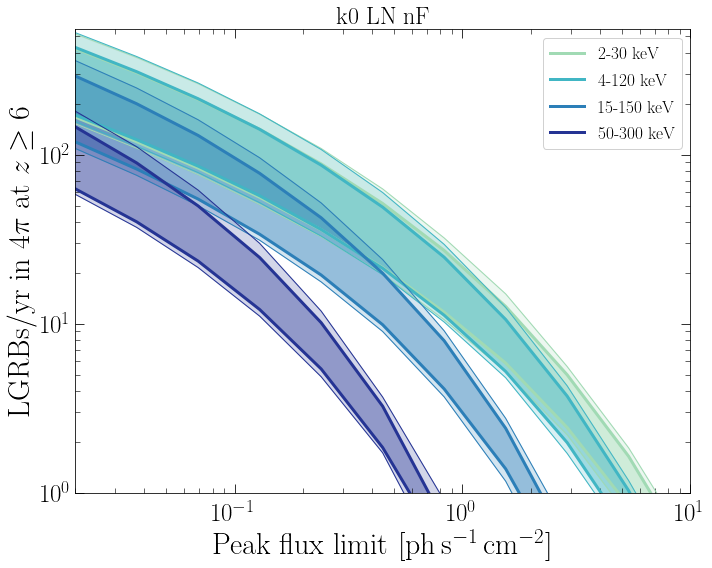

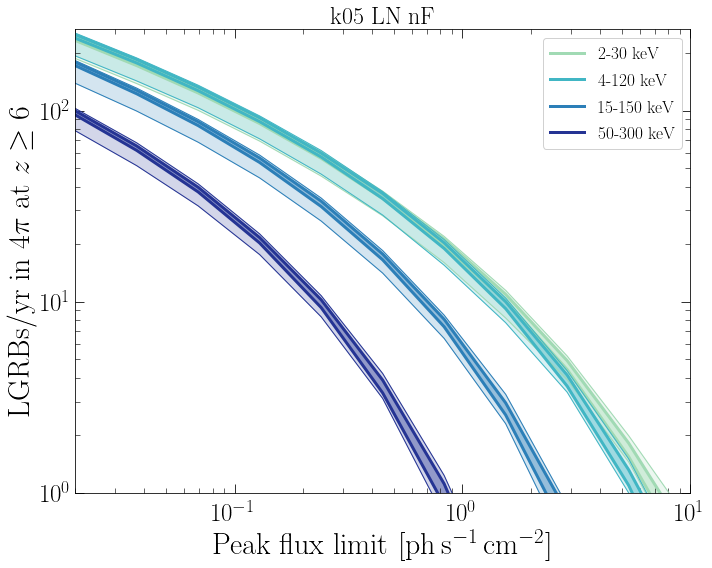

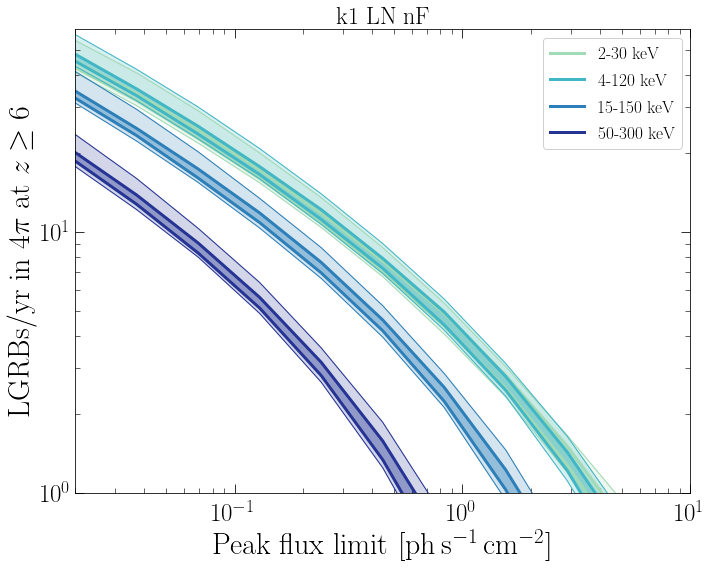

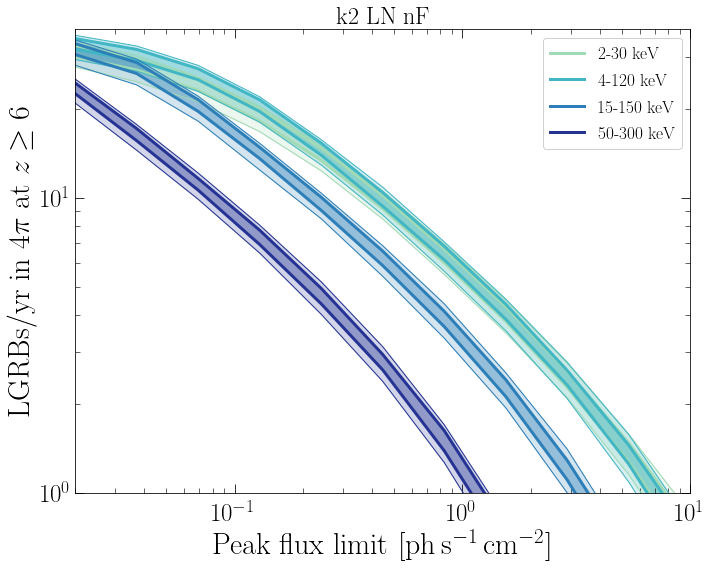

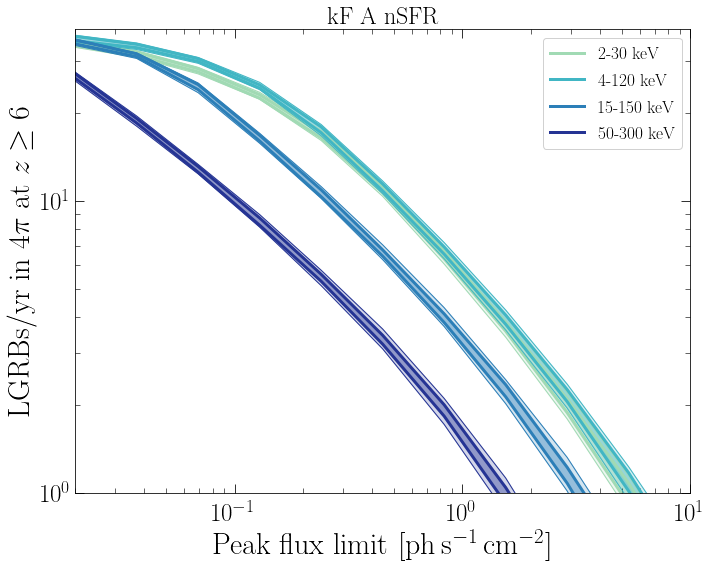

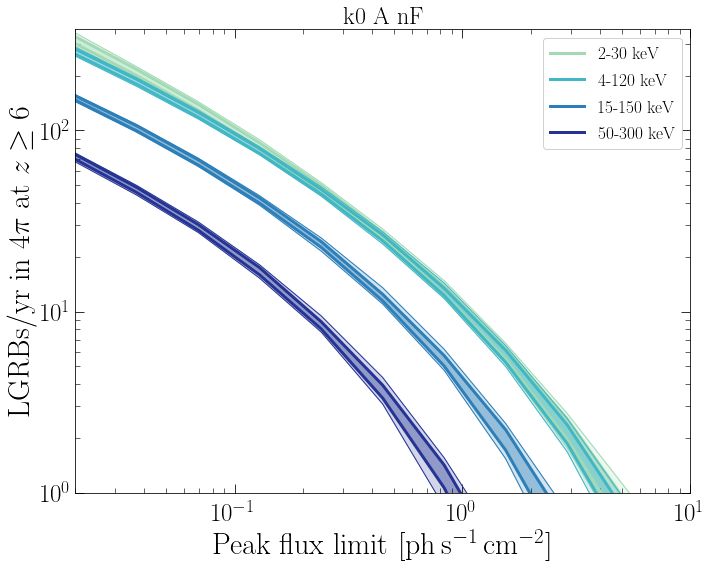

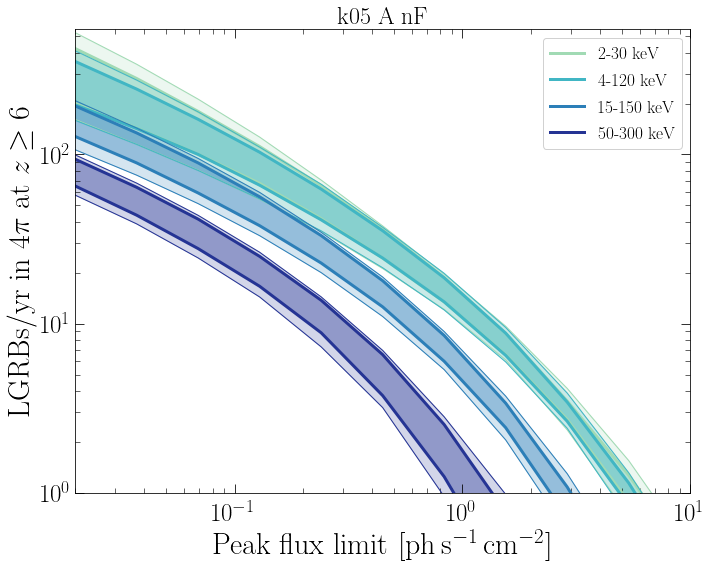

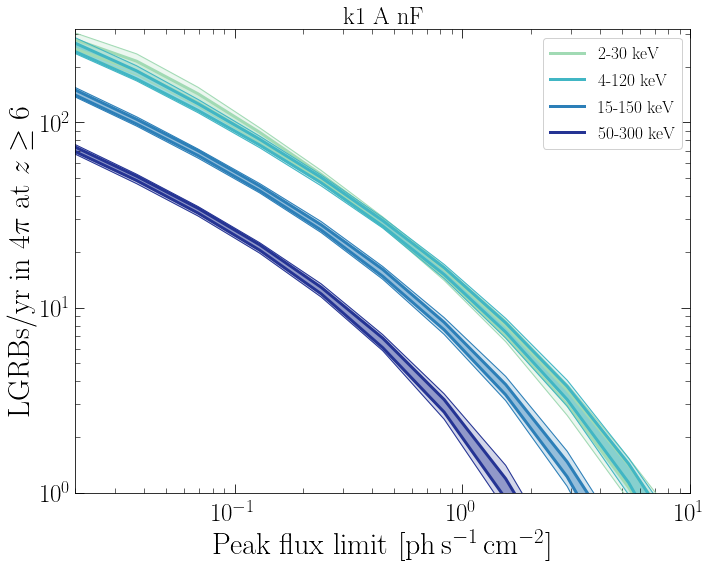

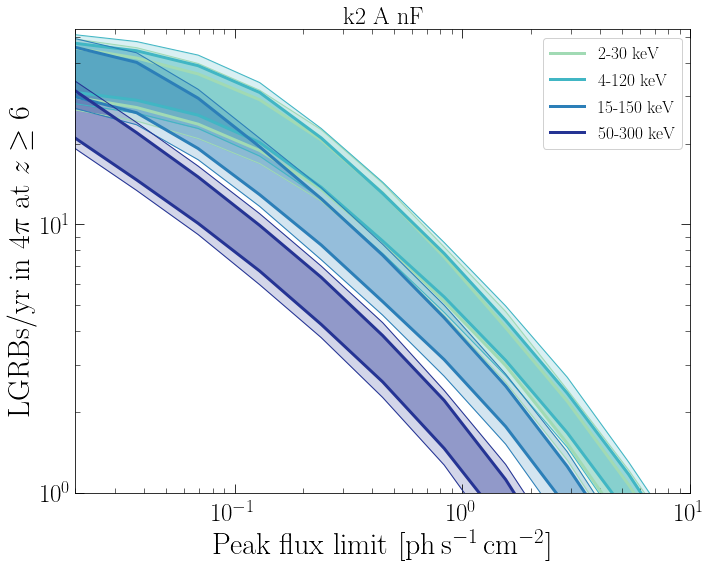

In [158]:
plt.style.use('paper')
_colors = ['#a1dab4','#41b6c4','#2c7fb8','#253494']

for mod in ['kF_LN_nSFR','k0_LN_nF', 'k05_LN_nF', 'k1_LN_nF', 'k2_LN_nF','kF_A_nSFR', 'k0_A_nF', 'k05_A_nF','k1_A_nF', 'k2_A_nF']:
    print(f" {mod} ".center(45, '#'))
    fig, ax = plt.subplots(figsize=(10,8))
    ax.set_title(mod.replace('_',' '))
    for i, k in enumerate(incl_instruments.keys()):
        q68 = mstats.mquantiles(R_highz[mod][:,:,i], prob=[0.16, 0.5, 0.84], axis=0)
        q95 = mstats.mquantiles(R_highz[mod][:,:,i], prob=[0.025, 0.5, 0.975], axis=0)
        ax.fill_between(pflx_cuts, q95[0], q68[0], color=_colors[i], alpha=0.2)
        ax.fill_between(pflx_cuts, q68[2], q95[2], color=_colors[i], alpha=0.2)
        ax.fill_between(pflx_cuts, q68[0], q68[2], color=_colors[i], alpha=0.5)
        ax.plot(pflx_cuts, q95[0], color=_colors[i], lw=1)
        ax.plot(pflx_cuts, q95[2], color=_colors[i], lw=1)
        ax.plot(pflx_cuts, q68[0], color=_colors[i])
        Emin = incl_instruments[k]['Emin']
        Emax = incl_instruments[k]['Emax']
        ax.plot(pflx_cuts, q68[2], label=f'{Emin:.0f}-{Emax:.0f} keV', color=_colors[i])
    ax.legend()
    ax.set_xlim(xmin=2e-2, xmax=10)
    ax.set_ylim(ymin=1)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'Peak flux limit $[\rm ph\,s^{-1}\,cm^{-2}]$')
    ax.set_ylabel(r'LGRBs/yr in $4\pi~{\rm at}~z\geq6$')

plt.show()

In [136]:

models = ['k0_LN_nF', 'k05_LN_nF', 'k1_LN_nF', 'k2_LN_nF', 'k0_A_nF', 'k05_A_nF','k1_A_nF', 'k2_A_nF']
R_high_z_low = {}
R_high_z_med = {}
R_high_z_upp = {}
for i, mod in enumerate(models):
    print(f" {mod} ".center(45, '#'))
    R_high_z_low[mod] = np.zeros((len(incl_instruments.keys()),len(pflx_cuts)))
    R_high_z_med[mod] = np.zeros((len(incl_instruments.keys()),len(pflx_cuts)))
    R_high_z_upp[mod] = np.zeros((len(incl_instruments.keys()),len(pflx_cuts))) 
    for j, k in enumerate(incl_instruments.keys()):
        q = mstats.mquantiles(R_highz[mod][:,:,j], prob=[0.025, 0.5, 0.975], axis=0)
        R_high_z_low[mod][j] = q[0]
        R_high_z_med[mod][j] = q[1]
        R_high_z_upp[mod][j] = q[2]


################## k0_LN_nF #################
################# k05_LN_nF #################
################## k1_LN_nF #################
################## k2_LN_nF #################
################## k0_A_nF ##################
################## k05_A_nF #################
################## k1_A_nF ##################
################## k2_A_nF ##################


In [138]:
R_high_z_med[mod].shape

(4, 11)

################## k0_A_nF ##################
################## k05_A_nF #################
################## k1_A_nF ##################
################## k2_A_nF ##################


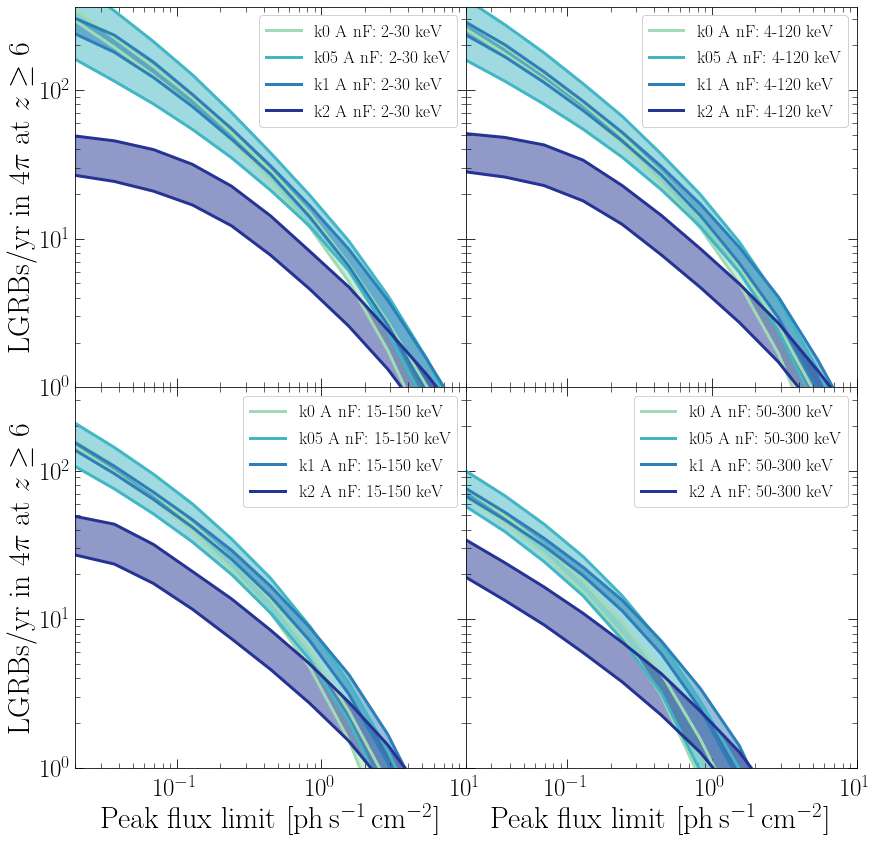

In [140]:
plt.style.use('paper')
_colors = {'k0_LN_nF':'#a1dab4',
           'k05_LN_nF':'#41b6c4',
           'k1_LN_nF':'#2c7fb8',
           'k2_LN_nF':'#253494',
           'k0_A_nF':'#a1dab4',
           'k05_A_nF':'#41b6c4',
           'k1_A_nF':'#2c7fb8',
           'k2_A_nF':'#253494'}
fig, axes = plt.subplots(2, 2, figsize=(14,14), tight_layout=False, sharex=True, sharey=True)

LN = False
if LN:
    save_str = 'LN'
else:
    save_str = 'A'

for mod in [m for m in models if save_str in m]:
    print(f" {mod} ".center(45, '#'))
    lab = mod.replace('_',' ')

    i = 0
    for k, ax in zip(incl_instruments.keys(), axes.flatten()):
    
        Emin = incl_instruments[k]['Emin']
        Emax = incl_instruments[k]['Emax']
#         low_tot = np.min(R_high_z_low[mod][i,:], axis=0)
#         upp_tot = np.max(R_high_z_upp[mod][i,:], axis=0)
        ax.fill_between(pflx_cuts, R_high_z_low[mod][i], R_high_z_upp[mod][i], color=_colors[mod], alpha=0.5)
        ax.plot(pflx_cuts, R_high_z_low[mod][i], color=_colors[mod])
        ax.plot(pflx_cuts, R_high_z_upp[mod][i], label=f'{lab}: {Emin:.0f}-{Emax:.0f} keV', color=_colors[mod])
#         ax.plot(pflx_cuts, low_tot, color='k', ls='--')
#         ax.plot(pflx_cuts, upp_tot, color='k', ls='--')
        ax.legend()
        i+=1
        ax.set_xlim(xmin=2e-2, xmax=10)
        ax.set_ylim(ymin=1)
        ax.set_xscale('log')
        ax.set_yscale('log')


axes[1,0].set_xlabel(r'Peak flux limit $[\rm ph\,s^{-1}\,cm^{-2}]$')
axes[1,1].set_xlabel(r'Peak flux limit $[\rm ph\,s^{-1}\,cm^{-2}]$')
axes[0,0].set_ylabel(r'LGRBs/yr in $4\pi~{\rm at}~z\geq6$')
axes[1,0].set_ylabel(r'LGRBs/yr in $4\pi~{\rm at}~z\geq6$')
axes[0,1].tick_params(axis='both', which='both', labelleft=False, labelbottom=False)
axes[1,1].tick_params(axis='y', which='both', labelleft=False)

fig.subplots_adjust(hspace=0, wspace=0)
fig.savefig(f'/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/high_z_rate_{save_str}.pdf', bbox_inches='tight')
plt.show()

THESEUS
ECLAIRsS
BAT
BATSE


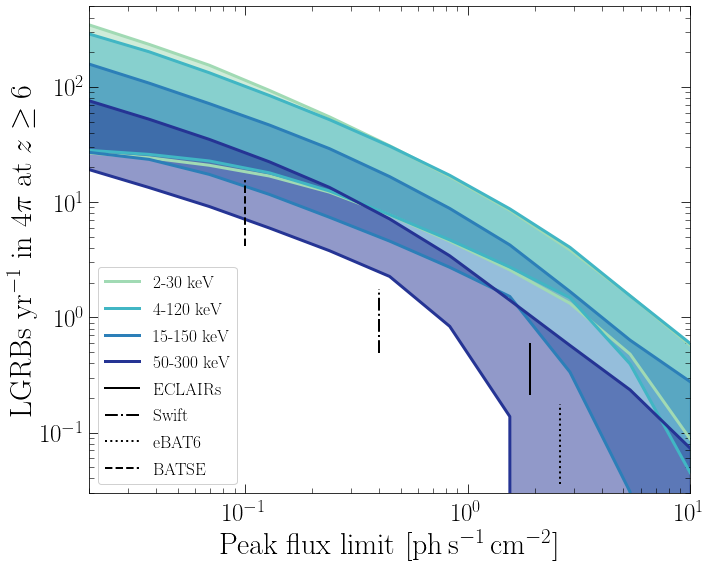

In [56]:
plt.style.use('paper')
from matplotlib.lines import Line2D

_colors = ['#a1dab4','#41b6c4','#2c7fb8','#253494']
fig, ax = plt.subplots()#2, 2, figsize=(14,14), tight_layout=False, sharex=True, sharey=True)

LN = False
if LN:
    mods = cycle(['k0_LN_nF', 'k05_LN_nF', 'k1_LN_nF', 'k2_LN_nF'])
    save_str = 'LN'
    ind_min = 0
    ind_max = 4
else:
    mods = cycle(['k0_A_nF', 'k1_A_nF', 'k2_A_nF'])
    save_str = 'A'
    ind_min = 4
    ind_max = 7


for i, k in enumerate(incl_instruments.keys()):
    print(k)
    Emin = incl_instruments[k]['Emin']
    Emax = incl_instruments[k]['Emax']
    low_tot = np.min(R_high_z_low[ind_min:ind_max,i,:], axis=0)
    upp_tot = np.max(R_high_z_upp[ind_min:ind_max,i,:], axis=0)
    ax.fill_between(pflx_cuts, low_tot, upp_tot, color=_colors[i], alpha=0.5)
    ax.plot(pflx_cuts, low_tot, color=_colors[i])
    ax.plot(pflx_cuts, upp_tot, label=f'{Emin:.0f}-{Emax:.0f} keV', color=_colors[i])

for i, k in enumerate(incl_instruments.keys()): 
    Emin = incl_instruments[k]['Emin']
    Emax = incl_instruments[k]['Emax']
    low_tot = np.min(R_high_z_low[ind_min:ind_max,i,:], axis=0)
    upp_tot = np.max(R_high_z_upp[ind_min:ind_max,i,:], axis=0)
    if k == 'BATSE':
        pflx_min = 0.1
        Omega_div4pi = 0.7
        y_low = Omega_div4pi*low_tot[pflx_cuts.searchsorted(pflx_min)]
        y_upp = Omega_div4pi*upp_tot[pflx_cuts.searchsorted(pflx_min)]
        instr_highz = Line2D([pflx_min,pflx_min], [y_low, y_upp], ls='--', lw=2, color='k', label=k)
        ax.add_line(instr_highz)
    elif k == 'BAT':
        pflx_min = 0.4
        Omega_div4pi = 1.33/(4*np.pi)
        y_low = Omega_div4pi*low_tot[pflx_cuts.searchsorted(pflx_min)]
        y_upp = Omega_div4pi*upp_tot[pflx_cuts.searchsorted(pflx_min)]
        instr_highz = Line2D([pflx_min,pflx_min], [y_low, y_upp], ls='-.', lw=2, color='k', label='Swift')
        ax.add_line(instr_highz)
        
        pflx_min = 2.6
        Omega_div4pi = 1.33/(4*np.pi)
        y_low = Omega_div4pi*low_tot[pflx_cuts.searchsorted(pflx_min)]
        y_upp = Omega_div4pi*upp_tot[pflx_cuts.searchsorted(pflx_min)]
        instr_highz = Line2D([pflx_min,pflx_min], [y_low, y_upp], ls=':', lw=2, color='k', label='eBAT6')
        ax.add_line(instr_highz)
    elif k == 'ECLAIRsS':
        pflx_min = 1.9
        Omega_div4pi = 1.83/(4*np.pi)
        y_low = Omega_div4pi*low_tot[pflx_cuts.searchsorted(pflx_min)]
        y_upp = Omega_div4pi*upp_tot[pflx_cuts.searchsorted(pflx_min)]
        instr_highz = Line2D([pflx_min,pflx_min], [y_low, y_upp], ls='-', lw=2, color='k', label='ECLAIRs')
        ax.add_line(instr_highz)
    ax.legend()
    ax.set_xlim(xmin=2e-2, xmax=10)
    ax.set_ylim(ymin=3e-2, ymax=500)
    ax.set_xscale('log')
    ax.set_yscale('log')

ax.set_xlabel(r'Peak flux limit $[\rm ph\,s^{-1}\,cm^{-2}]$')
ax.set_ylabel(r'${\rm LGRBs~yr^{-1}~in~4\pi~at}~z\geq6$')



fig.savefig(f'/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/high_z_rate_{save_str}_oneplot.pdf', bbox_inches='tight')
plt.show()


In [161]:
# SAVE DATA
import pickle
outfname = '../model_outputs_non-dockerized/best_populations/R_highz.pkl'
with open(outfname, 'wb') as f:
    pickle.dump(R_highz, f, protocol=-1)
outfname = '../model_outputs_non-dockerized/best_populations/likelihoods.pkl'
with open(outfname, 'wb') as f:
    pickle.dump(likelihoods, f, protocol=-1)
outfname = '../model_outputs_non-dockerized/best_populations/normalizations.pkl'
with open(outfname, 'wb') as f:
    pickle.dump(normalizations, f, protocol=-1)

In [7]:
# READ DATA
# import pickle
# outfname = '../model_outputs_non-dockerized/best_populations/R_highz.pkl'
# with open(outfname, 'rb') as f:
#     R_highz = pickle.load(f)
# outfname = '../model_outputs_non-dockerized/best_populations/likelihoods.pkl'
# with open(outfname, 'rb') as f:
#     likelihoods = pickle.load(f)
# outfname = '../model_outputs_non-dockerized/best_populations/normalizations.pkl'
# with open(outfname, 'rb') as f:
#     normalizations = pickle.load(f)

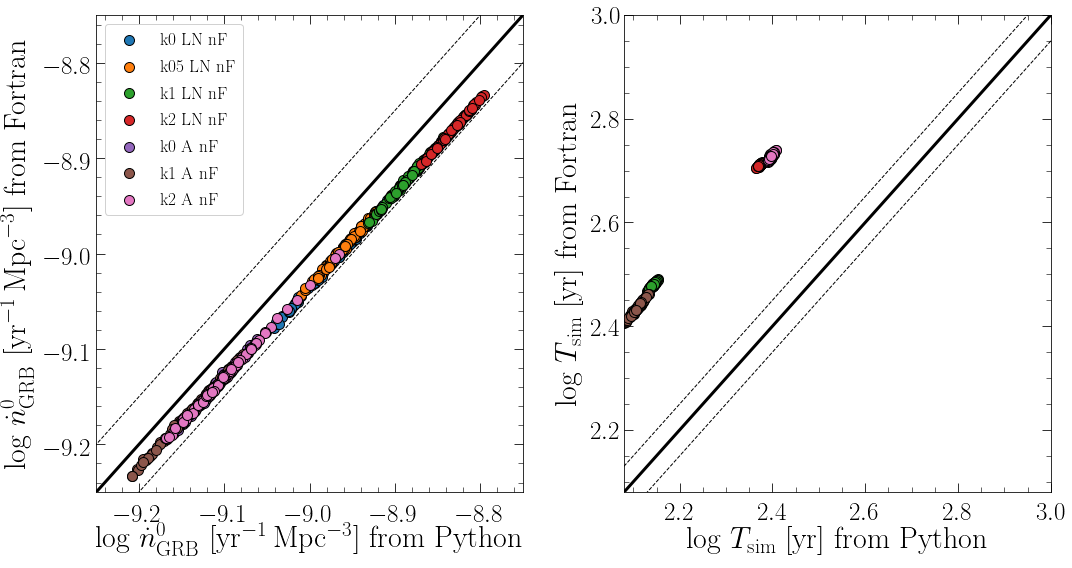

In [16]:
fig, axes = plt.subplots(1,2, figsize=(15,8))
mod = 'k0_A_nF'

x = np.linspace(-1000, 1000, 10)
dxlog = 0.05

for mod in ['k0_LN_nF', 'k05_LN_nF', 'k1_LN_nF', 'k2_LN_nF', 'k0_A_nF', 'k1_A_nF', 'k2_A_nF']:
    df = pd.read_pickle(f'../model_outputs_non-dockerized/best_populations/params_from_MCMC_{mod}.gzip')
    axes[0].scatter(np.log10(normalizations[mod][:,0]),
                    np.log10(df['nGRB0'].iloc[:N_models]), label=mod.replace('_',' '))
    axes[1].scatter(np.log10(normalizations[mod][:,1]),
                    np.log10(df['T_sim'].iloc[:N_models]), label=mod.replace('_',' '))

axes[0].legend()

axes[0].plot(x,x, color='k')
axes[0].plot(x,x-dxlog, ls='--', lw=1, color='k')
axes[0].plot(x,x+dxlog, ls='--', lw=1, color='k')
axes[0].set_xlim(-9.25, -8.75)
axes[0].set_ylim(-9.25, -8.75)
axes[0].set_xlabel(r'log $\dot{n}_{\rm GRB}^{0}~[\rm yr^{-1}\,Mpc^{-3}]$ from Python')
axes[0].set_ylabel(r'log $\dot{n}_{\rm GRB}^{0}~[\rm yr^{-1}\,Mpc^{-3}]$ from Fortran')


axes[1].plot(x,x, color='k')
axes[1].set_xlim(2.08, 3)
axes[1].set_ylim(2.08, 3)
axes[1].plot(x,x-dxlog, ls='--', lw=1, color='k')
axes[1].plot(x,x+dxlog, ls='--', lw=1, color='k')

axes[1].set_xlabel(r'log $T_{\rm sim}~[\rm yr]$ from Python')
axes[1].set_ylabel(r'log $T_{\rm sim}~[\rm yr]$ from Fortran')

plt.show()

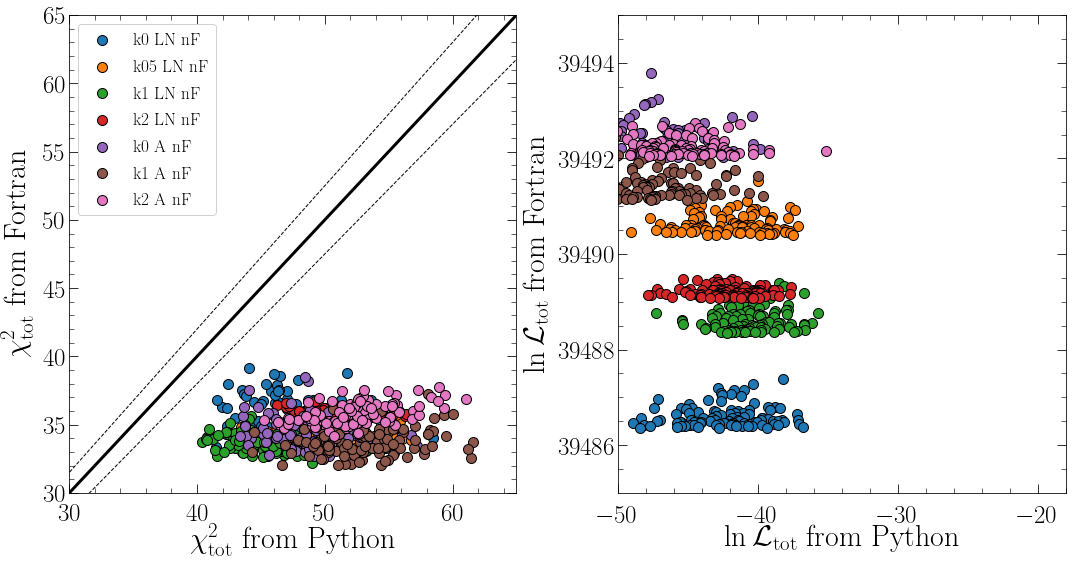

In [20]:
fig, axes = plt.subplots(1,2, figsize=(15,8))
mod = 'k0_A_nF'

x = np.linspace(-1000, 1000, 10)
dx = 0.05

for mod in ['k0_LN_nF', 'k05_LN_nF', 'k1_LN_nF', 'k2_LN_nF', 'k0_A_nF', 'k1_A_nF', 'k2_A_nF']:
    df = pd.read_pickle(f'../model_outputs_non-dockerized/best_populations/params_from_MCMC_{mod}.gzip')
    axes[0].scatter((likelihoods[mod][:,0]),
                    (df['chi2_tot'].iloc[:N_models]), label=mod.replace('_',' '))
    axes[1].scatter((likelihoods[mod][:,4]),
                    (df['lnL_tot'].iloc[:N_models]), label=mod.replace('_',' '))

axes[0].legend()

axes[0].plot(x,x, color='k')
axes[0].plot(x,x*(1-dx), ls='--', lw=1, color='k')
axes[0].plot(x,x*(1+dx), ls='--', lw=1, color='k')
axes[0].set_xlim(30, 65)
axes[0].set_ylim(30, 65)
axes[0].set_xlabel(r'$\chi^2_{\rm tot}$ from Python')
axes[0].set_ylabel(r'$\chi^2_{\rm tot}$ from Fortran')


axes[1].set_xlim(-50, -18)
axes[1].set_ylim(39485, 39495)
# axes[1].plot(x,x, color='k')
# axes[1].plot(x,x*(1-dx), ls='--', lw=1, color='k')
# axes[1].plot(x,x*(1+dx), ls='--', lw=1, color='k')

axes[1].set_xlabel(r'$\ln\mathcal{L}_{\rm tot}$ from Python')
axes[1].set_ylabel(r'$\ln\mathcal{L}_{\rm tot}$ from Fortran')

plt.show()

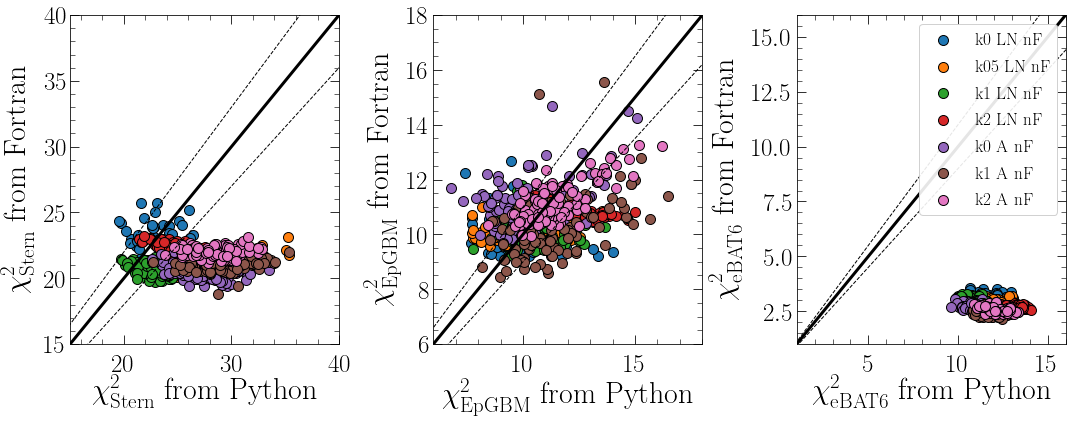

In [205]:
fig, axes = plt.subplots(1,3, figsize=(15,6))
mod = 'k0_A_nF'

x = np.linspace(-1000, 1000, 10)
dxlog = 0.05

for mod in ['k0_LN_nF', 'k05_LN_nF', 'k1_LN_nF', 'k2_LN_nF', 'k0_A_nF', 'k1_A_nF', 'k2_A_nF']:
    df = pd.read_pickle(f'../model_outputs_non-dockerized/best_populations/params_from_MCMC_{mod}.gzip')
    axes[0].scatter((likelihoods[mod][:,1]),
                    (df['chi2_Stern'].iloc[:N_models]), label=mod.replace('_',' '))
    axes[1].scatter((likelihoods[mod][:,2]),
                    (df['chi2_EpGBM'].iloc[:N_models]), label=mod.replace('_',' '))
    axes[2].scatter((likelihoods[mod][:,3]),
                    (df['chi2_eBAT6'].iloc[:N_models]), label=mod.replace('_',' '))
axes[2].legend()

axes[0].plot(x,x, color='k')
axes[0].plot(x,x*(1-dx), ls='--', lw=1, color='k')
axes[0].plot(x,x*(1+dx), ls='--', lw=1, color='k')
axes[0].set_xlim(15, 40)
axes[0].set_ylim(15, 40)
axes[0].set_xlabel(r'$\chi^2_{\rm Stern}$ from Python')
axes[0].set_ylabel(r'$\chi^2_{\rm Stern}$ from Fortran')

axes[1].plot(x,x, color='k')
axes[1].plot(x,x*(1-dx), ls='--', lw=1, color='k')
axes[1].plot(x,x*(1+dx), ls='--', lw=1, color='k')
axes[1].set_xlim(6, 18)
axes[1].set_ylim(6, 18)
axes[1].set_xlabel(r'$\chi^2_{\rm EpGBM}$ from Python')
axes[1].set_ylabel(r'$\chi^2_{\rm EpGBM}$ from Fortran')

axes[2].plot(x,x, color='k')
axes[2].plot(x,x*(1-dx), ls='--', lw=1, color='k')
axes[2].plot(x,x*(1+dx), ls='--', lw=1, color='k')
axes[2].set_xlim(1, 16)
axes[2].set_ylim(1, 16)
axes[2].set_xlabel(r'$\chi^2_{\rm eBAT6}$ from Python')
axes[2].set_ylabel(r'$\chi^2_{\rm eBAT6}$ from Fortran')

plt.show()

kF_LN_nSFR :  1.00e-09 +7.12e-12 -6.55e-12
k0_LN_nF :  1.08e-09 +8.16e-11 -1.15e-10
k05_LN_nF :  1.11e-09 +5.20e-11 -5.93e-11
k1_LN_nF :  1.30e-09 +5.90e-11 -4.84e-11
k2_LN_nF :  1.48e-09 +4.61e-11 -6.88e-11
kF_A_nSFR :  6.88e-10 +1.17e-11 -7.91e-12
k0_A_nF :  7.72e-10 +3.72e-11 -4.48e-11
k05_A_nF :  7.30e-10 +2.05e-10 -6.36e-11
k1_A_nF :  7.20e-10 +4.87e-11 -4.84e-11
k2_A_nF :  7.94e-10 +6.50e-11 -5.90e-11


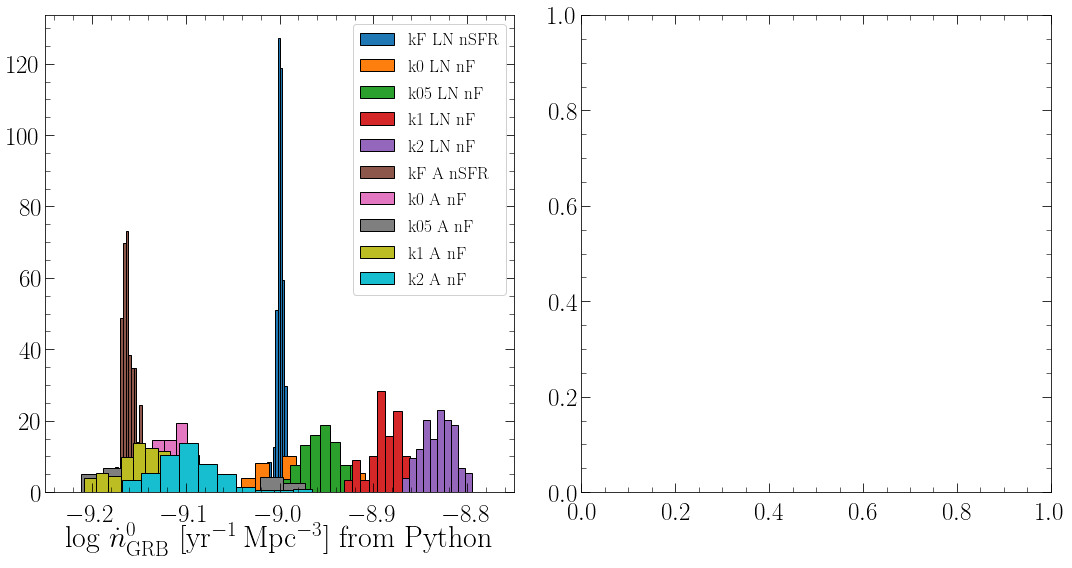

In [159]:
fig, axes = plt.subplots(1,2, figsize=(15,8))
mod = 'k0_A_nF'

x = np.linspace(-1000, 1000, 10)
dxlog = 0.05

for mod in ['kF_LN_nSFR','k0_LN_nF', 'k05_LN_nF', 'k1_LN_nF', 'k2_LN_nF','kF_A_nSFR', 'k0_A_nF', 'k05_A_nF','k1_A_nF', 'k2_A_nF']:
    q = mstats.mquantiles(normalizations[mod][:,0], prob=[0.16, 0.5, 0.84])
    stat = ' {:.2e} +{:.2e} -{:.2e}'.format(q[1], q[2]-q[1], q[1]-q[0])
    print(f"{mod} : "+ stat)
# df = pd.read_pickle(f'../model_outputs_non-dockerized/best_populations/params_from_MCMC_{mod}.gzip')
    axes[0].hist(np.log10(normalizations[mod][:,0]), label=mod.replace('_',' '), bins=10, density=True)

axes[0].legend()

axes[0].set_xlim(-9.25, -8.75)
# axes[0].set_ylim(-9.25, -8.75)
axes[0].set_xlabel(r'log $\dot{n}_{\rm GRB}^{0}~[\rm yr^{-1}\,Mpc^{-3}]$ from Python')
# axes[0].set_ylabel(r'log $\dot{n}_{\rm GRB}^{0}~[\rm yr^{-1}\,Mpc^{-3}]$ from Fortran')


# axes[1].plot(x,x, color='k')
# axes[1].set_xlim(2.08, 3)
# axes[1].set_ylim(2.08, 3)
# axes[1].plot(x,x-dxlog, ls='--', lw=1, color='k')
# axes[1].plot(x,x+dxlog, ls='--', lw=1, color='k')

# axes[1].set_xlabel(r'log $T_{\rm sim}~[\rm yr]$ from Python')
# axes[1].set_ylabel(r'log $T_{\rm sim}~[\rm yr]$ from Fortran')

plt.show()

In [145]:
x = 3
st = r'${}^{{3}}$'.format(x)
st

'$3^{3}$'